In [1]:
# Use sample CIFAR10 image
# Create a function that performs the jigsaw augmentation
# Should do number of pieces

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root="../../Data/", train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [3]:
import matplotlib.pyplot as plt
import numpy as np 
import math

def imshow(img):
    print(type(img))
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

In [12]:
# get some random training images
dataiter = iter(trainloader)

In [15]:
images, labels = dataiter.next()

In [16]:
classes[labels[0]]

'truck'

<class 'torch.Tensor'>


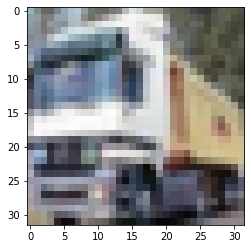

In [17]:
imshow(images[0])

In [19]:
images[0].shape

torch.Size([3, 32, 32])

In [58]:
#img = img.unfold(0, size, stride).unfold(1, size, stride).contiguous().reshape(-1, 1, size, size)
def improved_jigsaw(img, num_pieces=16):
    piece_size = img.shape[1] // math.isqrt(num_pieces)
    img = img.unfold(1, piece_size, piece_size).unfold(2, piece_size, piece_size).reshape(3, -1, piece_size, piece_size)
    perm = torch.randperm(num_pieces)
    img = img[:, perm, :, :]
    print(img.shape)
    return img

torch.Size([3, 4, 16, 16])
torch.Size([3, 4, 16, 16])
<class 'torch.Tensor'>


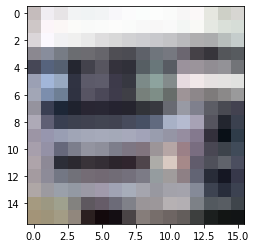

<class 'torch.Tensor'>


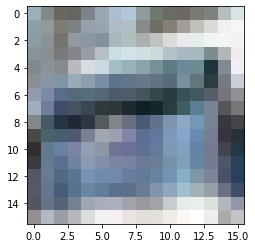

<class 'torch.Tensor'>


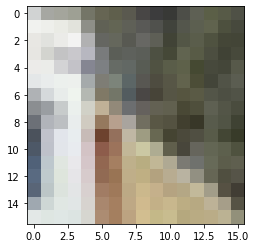

<class 'torch.Tensor'>


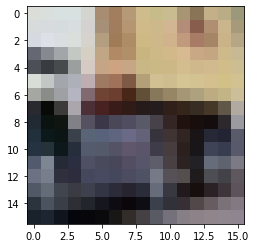

In [59]:
img = improved_jigsaw(images[0], num_pieces=4)
print(img.shape)
imshow(img[:, 0, :, :])
imshow(img[:, 1, :, :])
imshow(img[:, 2, :, :])
imshow(img[:, 3, :, :])

In [110]:
# How to get back to original shape while preserving the blocks? I want to put them back together as tensors
t = torch.arange(48).reshape(3, 4, 4)
s = t.unfold(1, 2, 2).unfold(2, 2, 2).reshape(3, -1, 2, 2)
print(s.shape)
printm = torch.randperm(4)
u = s[:, perm, :, :]
v = u.reshape(-1, 2, 2)
print(v.shape)
v = torch.nn.functional.fold(v, (2,2), 1, dilation=1, padding=0, stride=1)

torch.Size([3, 4, 2, 2])
torch.Size([12, 2, 2])


RuntimeError: Given output_size=(2, 2), kernel_size=(1, 1), dilation=(1, 1), padding=(0, 0), stride=(1, 1), expected size of input's dimension 2 to match the calculated number of sliding blocks 2 * 2 = 4, but got input.size(2)=2.

In [98]:
v

tensor([[[ 2,  3],
         [ 6,  7]],

        [[ 0,  1],
         [ 4,  5]],

        [[ 8,  9],
         [12, 13]],

        [[10, 11],
         [14, 15]],

        [[18, 19],
         [22, 23]],

        [[16, 17],
         [20, 21]],

        [[24, 25],
         [28, 29]],

        [[26, 27],
         [30, 31]],

        [[34, 35],
         [38, 39]],

        [[32, 33],
         [36, 37]],

        [[40, 41],
         [44, 45]],

        [[42, 43],
         [46, 47]]])

In [99]:
u

tensor([[[[ 2,  3],
          [ 6,  7]],

         [[ 0,  1],
          [ 4,  5]],

         [[ 8,  9],
          [12, 13]],

         [[10, 11],
          [14, 15]]],


        [[[18, 19],
          [22, 23]],

         [[16, 17],
          [20, 21]],

         [[24, 25],
          [28, 29]],

         [[26, 27],
          [30, 31]]],


        [[[34, 35],
          [38, 39]],

         [[32, 33],
          [36, 37]],

         [[40, 41],
          [44, 45]],

         [[42, 43],
          [46, 47]]]])

In [62]:
# Assuming channel first
# Assumptions - image is square, num_pieces is a perfect square
def jigsaw(img, num_pieces=9):
    print(type(img))
    if math.isqrt(num_pieces) ** 2 != num_pieces:
        print("Please use a perfect square")
    elif img.shape[-2] != img.shape[-1]:
        print("Please use a square image")
    elif img.shape[-2] % math.isqrt(num_pieces) != 0:
        print("Make sure the image size and number of pieces are compatible")
    print("Image and num_pieces are compatible")
    # Pixel size of one patch
    piece_size = img.shape[1] // math.isqrt(num_pieces)
    print(piece_size)
    # List to store patches
    pieces = []
    # Extract patches - is there a faster way to do this?
    for i in range(math.isqrt(num_pieces)):
        for j in range(math.isqrt(num_pieces)):
            pieces.append(img[:, piece_size*i:piece_size*(i+1), piece_size*j:piece_size*(j+1)])
    # Shuffle
    np.random.shuffle(pieces)
    # Reassemble
    new_img = np.zeros(img.shape)
    idx = 0
    for i in range(math.isqrt(num_pieces)):
        for j in range(math.isqrt(num_pieces)):
            new_img[:, piece_size*i:piece_size*(i+1), piece_size*j:piece_size*(j+1)] = pieces[idx]
            idx += 1
    return torch.Tensor(new_img)
    
    

In [71]:
new_img = jigsaw(images[0], num_pieces=)

<class 'torch.Tensor'>
Image and num_pieces are compatible
4


<class 'torch.Tensor'>


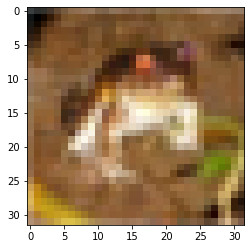

<class 'torch.Tensor'>


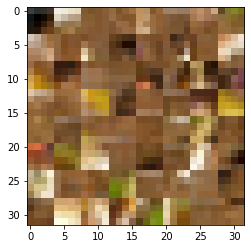

(None, None)

In [72]:
imshow(images[0]), imshow(new_img)

In [ ]:
# Rewrite jigsaw like a functional transform
# Two cases with square images and non-square images

def jigsaw(img: torch.Tensor, height: int, width: int) -> torch.Tensor:
    """Perform jigsaw transformation on an image.
    
    Args:
        img (Torch Tensor): Image to be adjusted. C x W x H 
        height (int): The number of horizontal pieces to divide the image into.
        width (int): The number of vertical pieces to divide the image into.
        
    Returns:
        Torch Tensor: Jigsaw transformed image.
    """
    if isinstance(height, int):
        if height <= 0:
            raise ValueError("Height must be strictly positive.")
    else:
        raise TypeError("Height must be a positive integer.")
        
    if isinstance(width, int):
        if width <= 0:
            raise ValueError("Width must be strictly positive.")
    else:
        raise TypeError("Width must be a positive integer.")
        
    if not isinstance(img, torch.Tensor):
        raise TypeError("Image must be a Torch Tensor.")
        
    assert height * width <= img.shape[1] * img.shape[2]
    
    blank_img = torch.zeros(img.shape)
    
    
    # Divide into grid
    # Shuffle
    # Reassemble
            